In [1]:
import json
import random

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [2]:
with open("./resume_corpus.txt", "r", encoding="utf-8") as f:
    all_text = f.read()
resume_corpus = [r.strip() for r in all_text.split('----------------------------------------') if r.strip()]

# 1.2. Job Descriptions
jd_df = pd.read_csv("job_descriptions.csv")
jd_texts = jd_df["Job Description"].fillna("").tolist()

# 1.3. Top matches (from your earlier step)
with open("top_matches.json", "r") as f:
    top_matches = json.load(f)
# Convert to dict for fast lookup
pos_pairs = set()
for entry in top_matches:
    i = entry["resume_index"]
    for m in entry["top_matches"]:
        pos_pairs.add((i, m["jd_index"]))

In [3]:
pairs = []
labels = []

n_resumes = len(resume_corpus)
n_jds = len(jd_texts)
neg_per_resume = len(top_matches[0]["top_matches"])  # same # negatives per resume as positives

for resume_idx in range(n_resumes):
    # 2.1 positive pairs
    for jd_idx in [m["jd_index"] for m in top_matches[resume_idx]["top_matches"]]:
        pairs.append((resume_idx, jd_idx))
        labels.append(1)
    # 2.2 negative pairs (random jds not in positives)
    negatives = set(range(n_jds)) - { jd for jd,_ in [(j,j) for j in []] }
    # actually simpler:
    used = {jd for jd,_ in [(j,j) for j in []]}
    used = set(j for j in range(n_jds) if (resume_idx, j) in pos_pairs)
    candidates = list(set(range(n_jds)) - used)
    sampled = random.sample(candidates, min(neg_per_resume, len(candidates)))
    for jd_idx in sampled:
        pairs.append((resume_idx, jd_idx))
        labels.append(0)

In [4]:
df = pd.DataFrame(pairs, columns=["resume_idx", "jd_idx"])
df["label"] = labels
df["text"] = df.apply(lambda r: resume_corpus[r.resume_idx] + " " + jd_texts[r.jd_idx], axis=1)

In [5]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(df["text"])
y = df["label"].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [8]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

Accuracy: 0.9516632016632016
              precision    recall  f1-score   support

           0     0.9833    0.9189    0.9500       962
           1     0.9239    0.9844    0.9532       962

    accuracy                         0.9517      1924
   macro avg     0.9536    0.9517    0.9516      1924
weighted avg     0.9536    0.9517    0.9516      1924



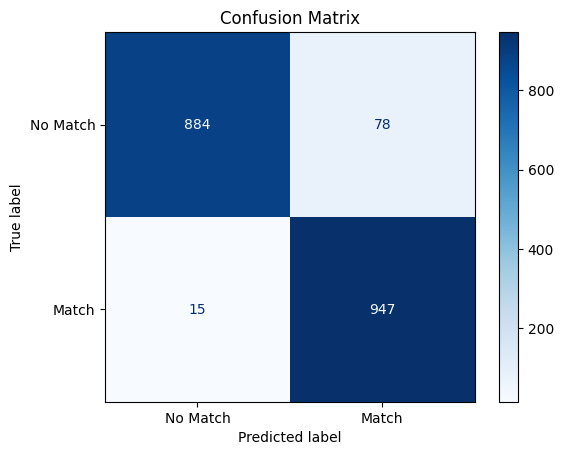

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Match', 'Match'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [10]:
import joblib

# Save the model
joblib.dump(clf, 'resume_job_matching_model.pkl')

print("Model saved as 'resume_job_matching_model.pkl'")

Model saved as 'resume_job_matching_model.pkl'


In [11]:
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']